# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

# Run DASK dist client 

In [2]:

cluster = LocalCluster()
client = Client(cluster)


In [3]:
cluster

LocalCluster(377a759c, 'tcp://127.0.0.1:44035', workers=5, threads=20, memory=31.04 GiB)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44035,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:42915,Total threads: 4
Dashboard: http://127.0.0.1:42117/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:36313,


In [5]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

# Read and merge

In [6]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022, 2023],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [7]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 51.9 ms, sys: 3.82 ms, total: 55.7 ms
Wall time: 54.7 ms


# Preprocessing

In [8]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
# cond = (bbdd_completa['year'].isin([2019]))
# bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
# index+=1
# print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')
# 14138178

(14138683, 23)
1
2
3
4
5
6
7
(14138178, 21)
Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -2 columns
CPU times: user 3.52 s, sys: 209 ms, total: 3.73 s
Wall time: 14.6 s


## Drop duplicate data

In [9]:
client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

In [10]:
def drop_duplicates_per_year(ddf):
    years = ddf.year.unique()
    
    before = get_ddf_shape(ddf)
    print(before)
    
    data = list()
    
    for year in years:
        print(year)
        data_year = ddf[ddf.year.isin([year])]
        
        data_year = data_year.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')
        
        data.append(data_year)
        
        client.run(trim_memory)
        
        time.sleep(1)
        
    ddf_clean = dd.concat(data, interleave_partitions=False)
    
    after = get_ddf_shape(ddf_clean)
    print(after)

    print('Changes to dataframe durinf preprocessing')
    print(f'dropeed {(after[0]-before[0]):02d} rows')
    print(f'dropped {(after[1]-before[1]):02d} columns')
    return ddf_clean


In [11]:
%%time

bbdd_completa = drop_duplicates_per_year(bbdd_completa)

(14138178, 21)
2019.0
2021.0
2022.0
2023.0
(13992397, 21)
Changes to dataframe durinf preprocessing
dropeed -145781 rows
dropped 00 columns
CPU times: user 7.65 s, sys: 560 ms, total: 8.21 s
Wall time: 32.6 s


## Drop not needed columns 

In [12]:
bbdd_completa = bbdd_completa.drop(
    columns=[
        'num_docks_available',
        'timestamp',
        'num_bikes_available_types.ebike',
        'num_bikes_available_types.mechanical',
        'num_bikes_available',
        'is_returning',
        'is_renting',
        'status'
    ]
)

# Additional datasets

## Festius 2019 - 2023 

In [13]:
client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

In [14]:
df_calendari_festius = pd.read_csv('./Altres_dades/calendari_festius.csv',sep=';')

In [15]:
df_calendari_festius['fecha'] = pd.to_datetime(df_calendari_festius['fecha'], format='%d/%m/%y')
df_calendari_festius.dtypes

fecha              datetime64[ns]
festius                    object
festius_sun                object
festius_sun_sat            object
dtype: object

In [16]:
df_calendari_festius['year'] = df_calendari_festius['fecha'].dt.year
df_calendari_festius['month'] = df_calendari_festius['fecha'].dt.month
df_calendari_festius['day'] = df_calendari_festius['fecha'].dt.day

In [17]:
df_calendari_festius['dayofweek'] = df_calendari_festius['fecha'].dt.dayofweek

In [18]:
type(df_calendari_festius)

pandas.core.frame.DataFrame

In [19]:
df_calendari_festius.drop('fecha', axis=1, inplace=True)

In [20]:
# replace IN_SERVICE with 0 and CLOSED with 1 
df_calendari_festius['festius'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)

df_calendari_festius['festius_sun'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)

df_calendari_festius['festius_sun_sat'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)


In [21]:
df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([5,6]), 'festius_sun_sat'] = 1
df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([6]), 'festius_sun'] = 1

In [22]:
df_calendari_festius['weekend'] = df_calendari_festius.dayofweek.isin([5,6]).astype(int)

In [23]:
df_calendari_festius[df_calendari_festius.year.isin([2019])].shape

(365, 8)

In [24]:
df_calendari_festius.loc[(df_calendari_festius.festius == 1) & (df_calendari_festius.festius_sun != 1), 'festius'] = 0 

In [25]:
df_calendari_festius.loc[(df_calendari_festius.month == 1) & (df_calendari_festius.day.isin([1,6])), ['festius','festius_sun','festius_sun_sat']] = 1

In [26]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2019])]

,festius,festius_sun,festius_sun_sat,year,month,day,dayofweek,weekend
0,1,1,1,2019,1,1,1,0
5,1,1,1,2019,1,6,6,1
108,1,1,1,2019,4,19,4,0
111,1,1,1,2019,4,22,0,0
120,1,1,1,2019,5,1,2,0
160,1,1,1,2019,6,10,0,0
174,1,1,1,2019,6,24,0,0
226,1,1,1,2019,8,15,3,0
253,1,1,1,2019,9,11,2,0
266,1,1,1,2019,9,24,1,0


In [27]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2022])]

,festius,festius_sun,festius_sun_sat,year,month,day,dayofweek,weekend
1096,1,1,1,2022,1,1,5,1
1101,1,1,1,2022,1,6,3,0
1200,1,1,1,2022,4,15,4,0
1203,1,1,1,2022,4,18,0,0
1252,1,1,1,2022,6,6,0,0
1270,1,1,1,2022,6,24,4,0
1322,1,1,1,2022,8,15,0,0
1362,1,1,1,2022,9,24,5,1
1364,1,1,1,2022,9,26,0,0
1380,1,1,1,2022,10,12,2,0


In [110]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2023])]

,festius,festius_sun,festius_sun_sat,year,month,day,weekend
1461,1,1,1,2023,1,1,1
1466,1,1,1,2023,1,6,0
1557,1,1,1,2023,4,7,0
1560,1,1,1,2023,4,10,0


In [28]:
df_calendari_festius.drop('dayofweek', axis=1, inplace=True)

## Meteo 2019 - 2023 

In [29]:
client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

In [30]:
df_meteo_metadata = pd.read_csv('./Altres_dades/MetadataMeteo/MeteoCat_Metadades.csv',sep=',')

In [31]:
df_meteo_metadata

,CODI_VARIABLE,NOM_VARIABLE,UNITAT,ACRÒNIM
0,1000,Temperatura mitjana diària,°C,TM
1,1001,Temperatura màxima diària + hora,°C,TX
2,1002,Temperatura mínima diària + hora,°C,TN
3,1100,Humitat relativa mitjana diària,%,HRM
4,1101,Humitat relativa màxima diària + data,%,HRX
5,1102,Humitat relativa mínima diària + data,%,HRN
6,1200,Pressió atmosfèrica mitjana diària,hPa,PM
7,1201,Pressió atmosfèrica màxima diària + hora,hPa,PX
8,1202,Pressió atmosfèrica mínima diària + hora,hPa,PN
9,1300,Precipitació acumulada diària,mm,PPT


In [32]:
df_estadistica_meteo_19_d5 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_d5_observatori_fabra.csv',sep=',')
df_estadistica_meteo_19_x2 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x2_barcelona_zoo.csv',sep=',')
df_estadistica_meteo_19_x4 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x4_barcelona_el_raval.csv',sep=',')
df_estadistica_meteo_19_x8 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x8_barcelona_zona_universitaria.csv',sep=',')

In [33]:
def convert_columns(data):
    print(data.shape)
    
    data.rename(
        columns={
            'PPT24H':'PPT',
            'DVX10':'DVVX10',
            'RS24H':'RS24h',
            'HPA':'PM'
        },
        inplace=True
    )
    
    for acro in df_meteo_metadata['ACRÒNIM'].values:
        if acro not in data.columns.values:
            data[acro] = np.nan
    
    code = data.CODI_ESTACIO.unique().tolist().pop()
    
    data.drop('CODI_ESTACIO', axis=1, inplace=True)

    data = data.set_index('DATA_LECTURA')

    data.columns = [f'VALOR_{col}_{code}' for col in data.columns.values]

    data = data.reset_index()

    data['DATA_LECTURA'] = pd.to_datetime(data['DATA_LECTURA'], format='%d/%m/%Y')
#     data['year'] = data['DATA_LECTURA'].dt.year
    
    print(data.shape)
    
    return data

In [34]:
df_estadistica_meteo_19_d5 = convert_columns(df_estadistica_meteo_19_d5)

df_estadistica_meteo_19_x2 = convert_columns(df_estadistica_meteo_19_x2)

df_estadistica_meteo_19_x4 = convert_columns(df_estadistica_meteo_19_x4)

df_estadistica_meteo_19_x8 = convert_columns(df_estadistica_meteo_19_x8)

(8766, 13)
(8766, 16)
(4832, 6)
(4832, 16)
(4809, 13)
(4809, 16)
(4262, 13)
(4262, 16)


In [35]:
df_estadistica_meteo_19 = pd.merge(
    pd.merge(
        df_estadistica_meteo_19_d5, df_estadistica_meteo_19_x2, 
        on='DATA_LECTURA',
        how='outer',
    ),
    pd.merge(
        df_estadistica_meteo_19_x4, df_estadistica_meteo_19_x8, 
        on='DATA_LECTURA',
        how='outer',
    ), 
    on='DATA_LECTURA',
    how='outer',
)


In [36]:
df_estadistica_meteo_19['year'] = df_estadistica_meteo_19['DATA_LECTURA'].dt.year

df_estadistica_meteo_19 = df_estadistica_meteo_19[df_estadistica_meteo_19.year.isin([2019])]

In [37]:
df_estadistica_meteo_20 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2020_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_21 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2021_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_22 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2022_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_23 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2023_MeteoCat_Detall_Estacions.csv',sep=',')


In [38]:
%%time 

df_estadistica_meteo_20.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_20.shape)

df_estadistica_meteo_21.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_21.shape)

df_estadistica_meteo_22.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_22.shape)

df_estadistica_meteo_23.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_23.shape)

df_20_21_22_23 = pd.concat([df_estadistica_meteo_20, df_estadistica_meteo_21, df_estadistica_meteo_22, df_estadistica_meteo_23])
print(df_20_21_22_23.shape)
#change indexing 
df_20_21_22_23 = pd.DataFrame(df_20_21_22_23.set_index(['ACRÒNIM', 'DATA_LECTURA', 'CODI_ESTACIO']).unstack(['ACRÒNIM']))
df_20_21_22_23 = df_20_21_22_23.reindex()
df_20_21_22_23 = df_20_21_22_23.unstack()
df_20_21_22_23.columns = ['_'.join(col) for col in df_20_21_22_23.columns.values]
df_20_21_22_23 = df_20_21_22_23.reset_index()

df_20_21_22_23['DATA_LECTURA'] = pd.to_datetime(df_20_21_22_23['DATA_LECTURA'], format='%Y-%m-%d')
df_20_21_22_23['year'] = df_20_21_22_23['DATA_LECTURA'].dt.year

# checking duplicates 
print('is there duplicates: ', (df_20_21_22_23.groupby('DATA_LECTURA').count().reset_index().VALOR_DVM10_D5 > 1 ).any())

print(df_20_21_22_23.shape)

(18637, 4)
(18615, 4)
(18605, 4)
(8007, 4)
(63864, 4)
is there duplicates:  False
(1253, 62)
CPU times: user 24.5 ms, sys: 8.07 ms, total: 32.6 ms
Wall time: 30.2 ms


In [39]:
df_estadistica_meteo = pd.concat([df_estadistica_meteo_19, df_20_21_22_23])

In [40]:
df_estadistica_meteo

,DATA_LECTURA,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_PM_X2,VALOR_PX_X2,VALOR_PN_X2,VALOR_PPT_X2,VALOR_RS24h_X2,VALOR_VVM10_X2,VALOR_DVM10_X2,VALOR_VVX10_X2,VALOR_DVVX10_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,year
8401,2019-01-01,10.5,14.4,7.8,73.0,0.0,979.6,5.4,3.8,339.0,15.8,315.0,NaN,NaN,NaN,NaN,9.9,15.4,4.9,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,16.0,8.4,66.0,0.0,1024.5,8.2,1.3,307.0,7.9,301.0,NaN,NaN,NaN,NaN,11.2,17.0,7.0,71.0,0.0,1019.0,7.4,1.4,311.0,9.0,303.0,NaN,NaN,NaN,NaN,2019
8402,2019-01-02,8.9,12.9,5.9,48.0,0.0,976.5,9.4,8.3,324.0,17.3,318.0,NaN,NaN,NaN,NaN,8.8,14.5,5.1,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.2,16.3,8.1,47.0,0.0,1021.4,9.2,1.0,280.0,6.3,309.0,NaN,NaN,NaN,NaN,9.5,15.3,5.7,52.0,0.0,1015.9,9.1,1.7,293.0,10.2,304.0,NaN,NaN,NaN,NaN,2019
8403,2019-01-03,8.3,12.6,4.9,59.0,0.0,979.0,9.1,4.0,279.0,9.9,313.0,NaN,NaN,NaN,NaN,7.6,13.0,4.1,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3,13.7,7.5,53.0,0.0,1024.3,8.9,1.1,264.0,4.6,263.0,NaN,NaN,NaN,NaN,8.8,13.4,4.4,59.0,0.0,1018.7,8.8,1.3,277.0,6.0,306.0,NaN,NaN,NaN,NaN,2019
8404,2019-01-04,7.2,11.3,5.3,69.0,0.0,980.6,8.0,2.0,205.0,7.8,290.0,NaN,NaN,NaN,NaN,7.0,11.7,3.3,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,12.3,6.4,59.0,0.0,1026.1,7.9,0.9,94.0,4.8,80.0,NaN,NaN,NaN,NaN,7.0,12.6,2.6,70.0,0.0,1020.5,7.7,1.2,292.0,4.1,164.0,NaN,NaN,NaN,NaN,2019
8405,2019-01-05,9.1,15.2,3.2,47.0,0.0,978.6,9.3,10.0,326.0,17.0,317.0,NaN,NaN,NaN,NaN,8.5,15.3,4.4,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9,16.3,6.8,45.0,0.0,1023.6,9.2,2.0,282.0,7.5,267.0,NaN,NaN,NaN,NaN,9.4,14.1,5.4,50.0,0.0,1018.1,9.2,3.1,296.0,10.8,307.0,NaN,NaN,NaN,NaN,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2023-06-02,18.9,24.7,15.4,80.0,0.0,966.5,24.3,2.0,202.0,7.1,157.0,100.0,56.0,967.5,965.2,20.1,24.1,16.9,79.0,93.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.8,23.2,18.2,74.0,0.0,1010.0,24.9,1.7,159.0,5.9,152.0,92.0,55.0,1011.0,1008.6,20.6,25.2,15.8,77.0,0.0,1004.4,23.5,1.5,207.0,6.1,174.0,99.0,54.0,1005.4,1003.0,2023
1249,2023-06-03,18.2,22.8,15.3,86.0,0.1,966.9,15.4,1.8,190.0,6.9,151.0,100.0,65.0,968.0,965.4,20.3,22.7,17.6,81.0,91.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.8,22.8,18.9,76.0,0.0,1010.5,18.2,1.6,149.0,6.6,174.0,91.0,59.0,1011.7,1009.0,20.5,25.3,16.9,78.0,0.0,1004.8,16.2,1.4,170.0,6.9,181.0,100.0,58.0,1006.1,1003.4,2023
1250,2023-06-04,19.1,25.7,16.2,82.0,0.0,967.8,21.6,1.8,184.0,7.0,167.0,100.0,51.0,969.0,966.6,20.5,24.5,17.9,81.0,91.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,23.9,18.9,76.0,0.0,1011.4,23.8,1.6,127.0,6.3,101.0,93.0,62.0,1012.6,1010.2,20.8,25.9,17.2,77.0,0.0,1005.7,22.5,1.4,176.0,6.3,132.0,99.0,51.0,1007.0,1004.6,2023
1251,2023-06-05,19.9,25.5,15.9,75.0,0.0,968.0,26.1,3.3,239.0,8.9,191.0,99.0,52.0,968.8,966.9,21.5,25.7,17.3,75.0,91.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,24.6,18.9,67.0,0.0,1011.5,28.6,1.8,193.0,7.7,155.0,80.0,56.0,1012.4,1010.0,21.8,26.5,16.7,70.0,0.0,1005.9,27.7,1.7,220.0,7.2,209.0,95.0,51.0,1006.8,1004.7,2023


In [41]:
df_estadistica_meteo['month'] = df_estadistica_meteo['DATA_LECTURA'].dt.month
df_estadistica_meteo['day'] = df_estadistica_meteo['DATA_LECTURA'].dt.day

In [42]:
df_estadistica_meteo.drop('DATA_LECTURA', axis=1, inplace=True)

In [43]:
%%time

nans = get_features_nans(df_estadistica_meteo)

zeros = get_features_zero(df_estadistica_meteo)

CPU times: user 7.16 ms, sys: 2.95 ms, total: 10.1 ms
Wall time: 9.58 ms


In [44]:
nans

{'VALOR_TM_D5': 0.061804697156983925,
 'VALOR_HRM_D5': 0.061804697156983925,
 'VALOR_RS24h_D5': 0.4326328800988875,
 'VALOR_VVM10_D5': 0.3708281829419036,
 'VALOR_DVM10_D5': 0.6180469715698393,
 'VALOR_VVX10_D5': 0.4326328800988875,
 'VALOR_DVVX10_D5': 0.30902348578491967,
 'VALOR_HRX_D5': 22.558714462299136,
 'VALOR_HRN_D5': 22.558714462299136,
 'VALOR_PX_D5': 22.558714462299136,
 'VALOR_PN_D5': 22.558714462299136,
 'VALOR_HRX_X2': 22.558714462299136,
 'VALOR_HRN_X2': 22.558714462299136,
 'VALOR_PM_X2': 100.0,
 'VALOR_PX_X2': 100.0,
 'VALOR_PN_X2': 100.0,
 'VALOR_PPT_X2': 100.0,
 'VALOR_RS24h_X2': 100.0,
 'VALOR_VVM10_X2': 100.0,
 'VALOR_DVM10_X2': 100.0,
 'VALOR_VVX10_X2': 100.0,
 'VALOR_DVVX10_X2': 100.0,
 'VALOR_VVM10_X4': 0.061804697156983925,
 'VALOR_DVM10_X4': 0.061804697156983925,
 'VALOR_HRX_X4': 22.558714462299136,
 'VALOR_HRN_X4': 22.558714462299136,
 'VALOR_PX_X4': 22.558714462299136,
 'VALOR_PN_X4': 22.558714462299136,
 'VALOR_HRX_X8': 22.558714462299136,
 'VALOR_HRN_X8': 

In [45]:
zeros

{'VALOR_PPT_D5': 77.07045735475896,
 'VALOR_DVM10_D5': 0.12360939431396785,
 'VALOR_DVVX10_D5': 0.30902348578491967,
 'VALOR_PPT_X4': 79.41903584672436,
 'VALOR_DVM10_X4': 0.061804697156983925,
 'VALOR_PPT_X8': 77.99752781211372}

In [46]:
nans = pd.Series(nans)

nancolumns = nans[nans >= 90].index.values
nancolumns

array(['VALOR_PM_X2', 'VALOR_PX_X2', 'VALOR_PN_X2', 'VALOR_PPT_X2',
       'VALOR_RS24h_X2', 'VALOR_VVM10_X2', 'VALOR_DVM10_X2',
       'VALOR_VVX10_X2', 'VALOR_DVVX10_X2'], dtype=object)

In [47]:
df_estadistica_meteo.drop(columns=nancolumns,axis=1, inplace=True)

In [48]:
df_estadistica_meteo.columns

Index(['VALOR_TM_D5', 'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5',
       'VALOR_PPT_D5', 'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5',
       'VALOR_DVM10_D5', 'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5',
       'VALOR_HRN_D5', 'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2',
       'VALOR_TX_X2', 'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2',
       'VALOR_HRN_X2', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4',
       'VALOR_HRM_X4', 'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4',
       'VALOR_VVM10_X4', 'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4',
       'VALOR_HRX_X4', 'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4',
       'VALOR_TM_X8', 'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8',
       'VALOR_PPT_X8', 'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8',
       'VALOR_DVM10_X8', 'VALOR_VVX10_X8', 'VALOR_DVVX10_X8', 'VALOR_HRX_X8',
       'VALOR_HRN_X8', 'VALOR_PX_X8', 'VALOR_PN_X8', 'year', 'month', 'day'],
      dtype='object')

# Split estaciones 2019 - 2022

## Part 1 

In [49]:
client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

In [50]:
%%time

bbdd_completa_19_22 = bbdd_completa[bbdd_completa.year.isin([2019, 2020, 2021, 2022])]

CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 1.48 ms


In [51]:
%%time

unique_ids_by_year = bbdd_completa_19_22.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

year
2019.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object
CPU times: user 2.83 s, sys: 168 ms, total: 3 s
Wall time: 13.1 s


In [52]:
# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2019])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print('total:',len(common_ids))

2019.0 (410,)
2021.0 (509,)
2022.0 (510,)
total: 408


In [53]:
filtered_bbdd = bbdd_completa_19_22[bbdd_completa_19_22['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa_19_22[~bbdd_completa_19_22['station_id'].isin(common_ids)]

In [54]:
bbdd_completa_19_22 = None

## Part 2 

In [55]:
client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

In [56]:
train_data2022 = filtered_bbdd[filtered_bbdd.year.isin([2019, 2022])] # 2021
get_ddf_shape(train_data2022)
#(3541851, 26)

(6993034, 13)

In [57]:
val_data2022= nonfiltered_bbdd[nonfiltered_bbdd.year.isin([2019, 2022])] # 2021
get_ddf_shape(val_data2022)
# (882910, 26)

(899816, 13)

In [58]:
val_data2023 = bbdd_completa[bbdd_completa.year.isin([2023])]
get_ddf_shape(val_data2023)
# (1694015, 26)

(1694015, 13)

# Convert to Pandas 

In [59]:
%%time 

# conversion a pandas
# datos de training de 2022
X_train, y_train = train_data2022.compute().copy(), train_data2022.ctx0.compute().copy()

CPU times: user 6.08 s, sys: 1.27 s, total: 7.35 s
Wall time: 33.5 s


In [60]:
%%time 

# conversion a pandas
# datos de validacion de 2022
X_val1, y_val1 = val_data2022.compute().copy(), val_data2022.ctx0.compute().copy()

CPU times: user 5.47 s, sys: 439 ms, total: 5.91 s
Wall time: 31.4 s


In [61]:
%%time 

# conversion a pandas
# datos de validacion de 2023
X_val2, y_val2 = val_data2023.compute().copy(), val_data2023.ctx0.compute().copy()

CPU times: user 4.95 s, sys: 556 ms, total: 5.5 s
Wall time: 24.8 s


# Shutdown DASK dist client

In [62]:
client.run(trim_memory)

{'tcp://127.0.0.1:34521': 1,
 'tcp://127.0.0.1:36633': 1,
 'tcp://127.0.0.1:37309': 1,
 'tcp://127.0.0.1:42915': 1,
 'tcp://127.0.0.1:44725': 1}

In [63]:
client.shutdown()

# Merge additional data

### Merge with data festius

In [64]:

X_train = pd.merge(X_train, df_calendari_festius, on=['year', 'month', 'day'], how='left')
X_val1 = pd.merge(X_val1, df_calendari_festius, on=['year', 'month', 'day'], how='left')
X_val2 = pd.merge(X_val2, df_calendari_festius, on=['year', 'month', 'day'], how='left')


### Merge with data meteo

In [65]:

X_train = pd.merge(X_train, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')
X_val1 = pd.merge(X_val1, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')
X_val2 = pd.merge(X_val2, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')


# Final Cleaning & preprocessing

In [66]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [70]:
X_val2.festius.fillna(0, inplace=True)
X_val2.festius_sun.fillna(0, inplace=True)
X_val2.festius_sun_sat.fillna(0, inplace=True)
X_val2.weekend.fillna(0, inplace=True)

X_val2.loc[X_val2.dayofweek.isin([5,6]),'weekend'] = 1
X_val2.loc[X_val2.dayofweek.isin([5,6]),'festius_sun_sat'] = 1
X_val2.loc[X_val2.dayofweek.isin([6]),'festius_sun'] = 1


In [71]:
%%time

nans = get_features_nans(X_val2)

zeros = get_features_zero(X_val2)

CPU times: user 3.54 s, sys: 216 ms, total: 3.76 s
Wall time: 3.73 s


In [72]:
nans

{}

In [73]:
zeros

{'dayofweek': 14.185175455943424,
 'hour': 4.079834003831135,
 'ctx0': 0.535532448059787,
 'ctx1': 0.5360046988958186,
 'ctx2': 0.5380117649489526,
 'ctx3': 0.5402549564201026,
 'ctx4': 0.5420258970552209,
 'festius': 98.01276848197921,
 'festius_sun': 86.1966983763426,
 'festius_sun_sat': 61.14261089777836,
 'weekend': 74.54638831415306,
 'VALOR_PPT_D5': 78.02894307311328,
 'VALOR_PPT_X4': 77.99588551459108,
 'VALOR_PPT_X8': 77.99381941718345}

In [74]:
%%time

nans = get_features_nans(pd.concat([X_train, X_val1, X_val2]))

zeros = get_features_zero(pd.concat([X_train, X_val1, X_val2]))

CPU times: user 21.4 s, sys: 2.36 s, total: 23.8 s
Wall time: 23.6 s


In [75]:
nans

{'VALOR_TM_D5': 0.12692366065444752,
 'VALOR_HRM_D5': 0.12692366065444752,
 'VALOR_VVM10_D5': 0.12692366065444752,
 'VALOR_DVM10_D5': 0.6357761374547363,
 'VALOR_VVX10_D5': 0.2545357632552456,
 'VALOR_HRX_D5': 36.17542335268099,
 'VALOR_HRN_D5': 36.17542335268099,
 'VALOR_PX_D5': 36.17542335268099,
 'VALOR_PN_D5': 36.17542335268099,
 'VALOR_HRX_X2': 36.17542335268099,
 'VALOR_HRN_X2': 36.17542335268099,
 'VALOR_HRX_X4': 36.17542335268099,
 'VALOR_HRN_X4': 36.17542335268099,
 'VALOR_PX_X4': 36.17542335268099,
 'VALOR_PN_X4': 36.17542335268099,
 'VALOR_HRX_X8': 36.17542335268099,
 'VALOR_HRN_X8': 36.17542335268099,
 'VALOR_PX_X8': 36.17542335268099,
 'VALOR_PN_X8': 36.17542335268099}

In [76]:
zeros

{'dayofweek': 14.287465193261822,
 'hour': 4.145901710308844,
 'ctx0': 1.0987116226211593,
 'ctx1': 1.09959825240055,
 'ctx2': 1.1008499650302783,
 'ctx3': 1.1019660754584528,
 'ctx4': 1.102310296431628,
 'festius': 96.37142068861927,
 'festius_sun': 82.64221932821626,
 'festius_sun_sat': 55.43530653659982,
 'weekend': 71.8825392868263,
 'VALOR_PPT_D5': 78.14764263395803,
 'VALOR_DVM10_D5': 0.22579852746440052,
 'VALOR_DVVX10_D5': 0.20428993211023624,
 'VALOR_PPT_X4': 81.25623965707246,
 'VALOR_PPT_X8': 79.25950767012992}

# Save prepared data to a file 

In [77]:
%%time 

X_train.to_csv('dades/processed/training_data.csv', header=True, index=True, index_label='index')
y_train.to_csv('dades/processed/training_label.csv', header=True, index=True, index_label='index')

CPU times: user 2min 51s, sys: 3.35 s, total: 2min 54s
Wall time: 2min 52s


In [78]:
%%time 

X_val1.to_csv('dades/processed/validation_data.csv', header=True, index=True, index_label='index')
y_val1.to_csv('dades/processed/validation_label.csv', header=True, index=True, index_label='index')

CPU times: user 23.5 s, sys: 350 ms, total: 23.8 s
Wall time: 23.6 s


In [79]:
%%time 

X_val2.to_csv('dades/processed/testing_data.csv', header=True, index=True, index_label='index')
y_val2.to_csv('dades/processed/testing_label.csv', header=True, index=True, index_label='index')

CPU times: user 45 s, sys: 833 ms, total: 45.8 s
Wall time: 45.3 s


# Run pipeline

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [81]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [82]:
%%time 

correlations = np.abs(
    X_train.corr(method='pearson').ctx0
).sort_values(ascending=False)

# num_docks_available                     0.880782
# timestamp                               0.024289
# num_bikes_available_types.ebike        -0.393887
# num_bikes_available_types.mechanical   -0.755995
# num_bikes_available                    -0.865541
# is_returning                            0.006442
# is_renting                              0.006442
# status                                  0.006277

correlations.to_dict()

CPU times: user 46.3 s, sys: 575 ms, total: 46.9 s
Wall time: 46.7 s


{'ctx0': 1.0,
 'ctx1': 0.922782456240714,
 'ctx2': 0.819636295322785,
 'ctx3': 0.7269660619171394,
 'ctx4': 0.6433542864387456,
 'VALOR_TN_X2': 0.06622019805741854,
 'VALOR_TN_X8': 0.06003579235461014,
 'station_id': 0.058572666456470864,
 'VALOR_PM_X4': 0.0580756477957544,
 'VALOR_TN_X4': 0.0578433698087347,
 'VALOR_PM_X8': 0.05764335681349184,
 'VALOR_TM_X2': 0.05572976208414345,
 'VALOR_TM_X4': 0.053008809842054104,
 'VALOR_TM_X8': 0.0528488143256557,
 'VALOR_PM_D5': 0.051855439890663095,
 'VALOR_TN_D5': 0.050139486868618445,
 'month': 0.04797209212986377,
 'dayofyear': 0.04658815108186215,
 'VALOR_TM_D5': 0.045422914939544014,
 'VALOR_TX_X4': 0.04464520907775264,
 'VALOR_TX_X8': 0.0405173910222145,
 'VALOR_TX_X2': 0.03904925847747224,
 'VALOR_VVM10_X4': 0.03768656683893126,
 'VALOR_TX_D5': 0.03482090288856406,
 'VALOR_RS24h_X4': 0.03470144618041361,
 'VALOR_RS24h_X8': 0.0324440662216086,
 'VALOR_HRM_D5': 0.03166378247914909,
 'VALOR_DVM10_D5': 0.02973247543891754,
 'VALOR_RS24h_D5'

In [84]:
correlations['VALOR_PPT_X4']

0.02092181075580436

In [85]:
columns = correlations.index[['VALOR' not in i for i in correlations.index]].to_list()

In [87]:
columns, len(columns)

(['ctx0',
  'ctx1',
  'ctx2',
  'ctx3',
  'ctx4',
  'station_id',
  'month',
  'dayofyear',
  'festius',
  'festius_sun',
  'hour',
  'weekend',
  'festius_sun_sat',
  'dayofweek',
  'day',
  'year',
  'capacity'],
 17)

In [ ]:
columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']

class Config:
    num_attribs0 = ['year', 'capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4'] + columns_meteo
    cat_attribs0 = ['month', 'dayofyear', 'day', 'hour']
    cat_attribs1 = ['station_id'] # dayofweek
    gen_attribs0 = ['festius_sun', 'weekend'] # year
    target_col = ['ctx0']

    seed=42

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [ ]:
config=Config()
seed_everything(config.seed)

In [ ]:
def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [88]:
%%time 

full_pipeline = build_preprocessor(config)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared1 = full_pipeline.transform(X_val1)
X_val_prepared2 = full_pipeline.transform(X_val2)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",X_val_prepared1.shape,"y_test: ",y_val1.shape)
print("x_test_prepared:",X_val_prepared2.shape,"y_test: ",y_val2.shape)

# Predicción______________________________

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [92]:
%%time 

lin_reg = LinearRegression(n_jobs=5)
cross_val_evaluation(lin_reg,X_train_prepared, y_train,'Linear Regression', n_jobs=5)

# Linear Regression
# Scores: [0.86876116 0.85690033 0.83716171 0.82008556 0.8135665 ]
# Mean: 0.8392950517172396
# Standard deviation: 0.021041440859117303

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.4s remaining:   23.2s



  Linear Regression
Scores: [-0.10989193 -0.1097628  -0.11196599 -0.11317847 -0.11298029]
Mean: -0.11155589536322592
Standard deviation: 0.0014706319997068616
CPU times: user 370 ms, sys: 615 ms, total: 985 ms
Wall time: 16.4 s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.3s finished


In [93]:
%%time 

lin_reg.fit(X_train_prepared,y_train)

CPU times: user 23.5 s, sys: 56.8 s, total: 1min 20s
Wall time: 9.04 s


LinearRegression(n_jobs=5)


Training time: 0.167 s
----- EVALUATION ON VAL SET ------
MSE: 0.012399658838366382
RMSE 0.11135375538510761
MAE: 0.0718719949734375
R^2:  0.8604976916495185



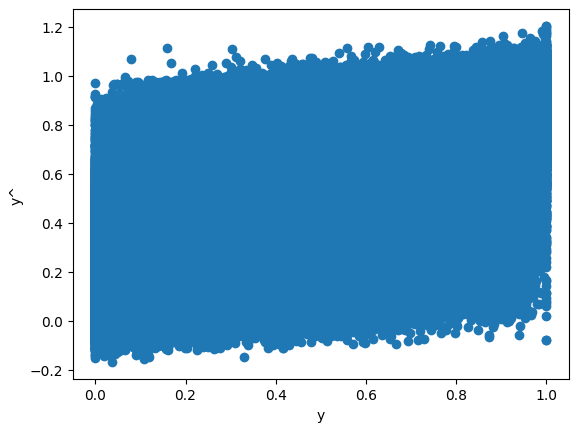

y_hat_t    [0.22350376068618438, 0.08140633871560365, 0.0...
mse_t                                                 0.0124
rmse_t                                              0.111354
mae_t                                               0.071872
r2_t                                                0.860498
dtype: object

In [94]:
test_model(lin_reg, X_train_prepared, y_train)


Training time: 0.02 s
----- EVALUATION ON VAL SET ------
MSE: 0.009034060366552967
RMSE 0.09504767417750404
MAE: 0.06133597233804747
R^2:  0.8627977384114307



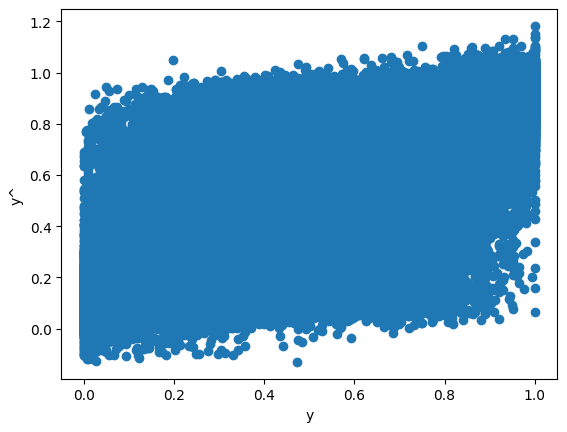


Testing time: 0.037 s
----- EVALUATION ON VAL SET ------
MSE: 0.013104938674596374
RMSE 0.11447680408972105
MAE: 0.07513443183963078
R^2:  0.8178282427305555



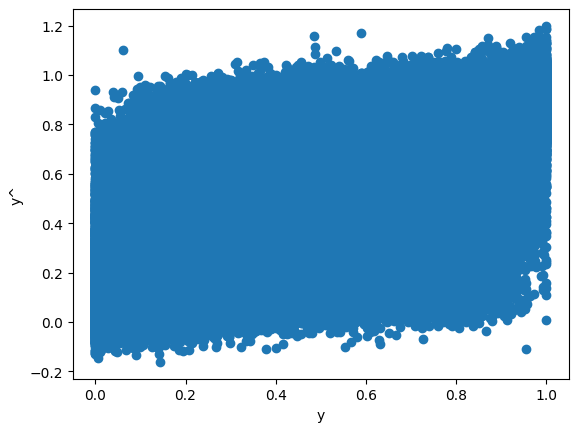

y_hat_t    [0.5179921230156954, 0.9241495839768377, 0.917...
mse_t                                               0.009034
rmse_t                                              0.095048
mae_t                                               0.061336
r2_t                                                0.862798
y_hat_v    [0.17005339303501854, 0.1730058499742862, 0.25...
mse_v                                               0.013105
rmse_v                                              0.114477
mae_v                                               0.075134
r2_v                                                0.817828
dtype: object

In [95]:
test_model(lin_reg, X_val_prepared1, y_val1, X_val_prepared2, y_val2)

## Generate Sample

In [96]:
sample_data = pd.read_csv('dades/metadata_sample_submission.csv/metadata_sample_submission.csv')

In [97]:
sample_data['year'] = 2023

In [98]:
sample_data['datetime'] = pd.to_datetime(sample_data[['year','month','day']])
sample_data['dayofweek'] = sample_data.datetime.dt.dayofweek
sample_data['dayofyear'] = sample_data.datetime.dt.dayofyear

In [99]:
sample_data.drop(['datetime', 'index'], axis=1, inplace=True)

In [100]:
sample_data.rename(
    columns = {
        'ctx-4':'ctx4',
        'ctx-3':'ctx3',
        'ctx-2':'ctx2',
        'ctx-1':'ctx1'
    },
    inplace=True
)

In [101]:
sample_data

,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek,dayofyear
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63
...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73
54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60
54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79
54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73


# Merge additional data

### Merge with data festius

In [102]:

sample_data = pd.merge(sample_data, df_calendari_festius, on=['year', 'month', 'day'], how='left')


### Merge with data meteo

In [103]:

sample_data = pd.merge(sample_data, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')


# merge capacity 

In [104]:
X_train.capacity = X_train.capacity.astype(int)

In [105]:
station_capacity = X_train.groupby(['station_id']).capacity.max()


In [106]:
station_capacity = station_capacity.reset_index()

In [107]:

sample_data = pd.merge(sample_data, station_capacity, on=['station_id'], how='left')


# check columns that does not intersect and save sample data modified to file 

In [108]:
[x for x in X_train.columns if x not in sample_data.columns]

['ctx0']

In [109]:
%%time 

sample_data.to_csv('dades/processed/kaggle_sample_data.csv', header=True, index=True, index_label='index')


CPU times: user 1.33 s, sys: 33.2 ms, total: 1.36 s
Wall time: 1.35 s


# apply pipeline

In [113]:
X_test_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",X_val_prepared1.shape,"y_test: ",y_val1.shape)
print("x_test_prepared:",X_val_prepared2.shape,"y_test: ",y_val2.shape)
print("x_test_prepared:",X_test_prepared.shape)

x_train_prepared: (6993034, 424) y_train:  (6993034,)
x_test_prepared: (899816, 424) y_test:  (899816,)
x_test_prepared: (1694015, 424) y_test:  (1694015,)
x_test_prepared: (54999, 424)


In [114]:
%%time 

lin_reg = LinearRegression(n_jobs=5)
cross_val_evaluation(lin_reg,X_train_prepared, y_train,'Linear Regression', n_jobs=5)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.7s remaining:   22.0s



  Linear Regression
Scores: [-0.10989118 -0.10976282 -0.11196599 -0.11317808 -0.11298196]
Mean: -0.11155600604316858
Standard deviation: 0.001471034654745499
CPU times: user 396 ms, sys: 656 ms, total: 1.05 s
Wall time: 15.1 s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.0s finished


In [115]:
lin_reg.fit(X_train_prepared,y_train)

LinearRegression(n_jobs=5)


Training time: 0.161 s
----- EVALUATION ON VAL SET ------
MSE: 0.012399657264261057
RMSE 0.1113537483170686
MAE: 0.07187240041704024
R^2:  0.8604977093589837



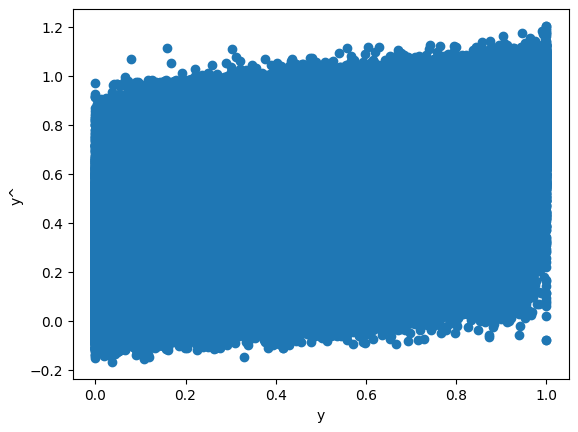

y_hat_t    [0.22351420537080174, 0.08141816276784503, 0.0...
mse_t                                                 0.0124
rmse_t                                              0.111354
mae_t                                               0.071872
r2_t                                                0.860498
dtype: object

In [116]:
test_model(lin_reg, X_train_prepared, y_train)


Training time: 0.021 s
----- EVALUATION ON VAL SET ------
MSE: 0.009034206792323614
RMSE 0.09504844444978368
MAE: 0.06133789409704985
R^2:  0.8627955146110494



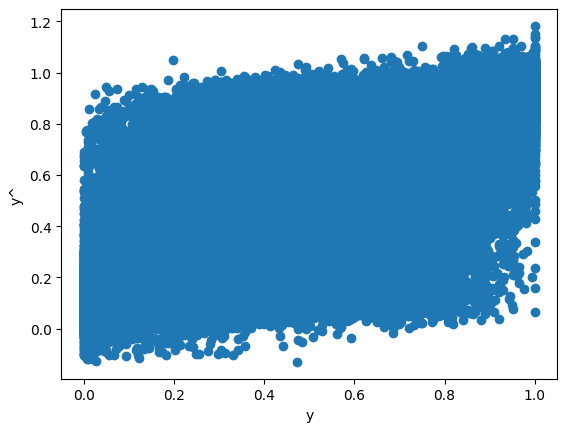


Testing time: 0.038 s
----- EVALUATION ON VAL SET ------
MSE: 0.013104957983692687
RMSE 0.11447688842597308
MAE: 0.0751349494566934
R^2:  0.8178279743148007



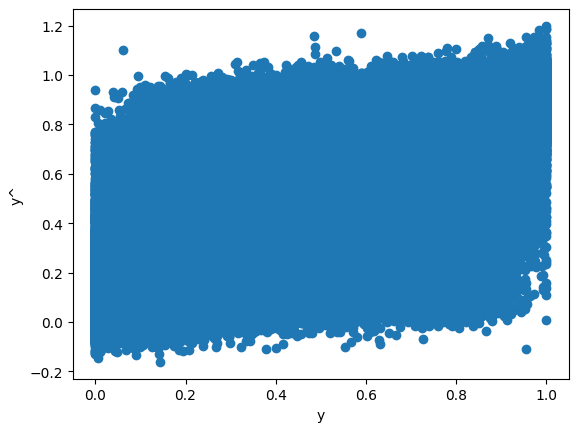

y_hat_t    [0.5179996545063613, 0.9241539751292878, 0.917...
mse_t                                               0.009034
rmse_t                                              0.095048
mae_t                                               0.061338
r2_t                                                0.862796
y_hat_v    [0.1700600579613573, 0.17301276234606755, 0.25...
mse_v                                               0.013105
rmse_v                                              0.114477
mae_v                                               0.075135
r2_v                                                0.817828
dtype: object

In [117]:
test_model(lin_reg, X_val_prepared1, y_val1, X_val_prepared2, y_val2)

In [118]:
yhat = lin_reg.predict(X_test_prepared)

In [119]:
yhat.shape

(54999,)

In [120]:
sample_data['percentage_docks_available'] = yhat

In [122]:
sample_data['percentage_docks_available'].to_csv('predicton_lr.csv', header=True, index_label='index')